In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')
#maap = MAAP()

In [2]:
maap._MAAP_HOST

'api.maap-project.org'

In [3]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

# Launch DPS for build_stack.py

In [4]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade

In [20]:
import os
import geopandas
import pandas as pd
import glob
import datetime
!pip install xmltodict
import xmltodict
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import json
import rasterio

In [6]:
import s3fs
s3fs.__version__

'2023.12.2'

# Test (locally) the script for DPS

##### To run build_stack.py across a tiled raster dataset you need a bunch of args that we'll gather into a dictionary

s3 you need to have a vector footprint of that dataset

In [7]:
TILE_NUM = 3459 #354000 #685 # tmp2.gpkg has the subtiles in siberia for this boreal tile

#### Dictionary preparation makes this script very flexible and transferable to another s3 dataset
This dictionary is specific to the ESA Worldcover dataset.  
To run '`build_stack.py` across another dataset, just prepare another dictionary here and everything below should be exactly the same.  

In [8]:
COVAR = 'EXPORT_GEE_v6/SAR_S1_2019'
#COVAR = 'EXPORT_GEE_v3/SAR_S1_2018'

In [194]:
BUILD_STACK_DICT_S1 = {
            # Test S1 on tile 3736 in western AK where subtiles overlap near AGG tile boundary 
            # https://maap-ops-workspace.s3.amazonaws.com/
            'INDEX_FN': '/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg',
            'ID_COL_NAME': 'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR': 'boreal_tiles_v004',
            'COVAR_SRC_NAME': 'SAR_S1_2019',
            'BANDNAMES_LIST': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer n_frozen n_summer n_shoulder',
            'COVAR_TILE_FN': f'/projects/shared-buckets/montesano/DPS_tile_lists/SAR/{COVAR}/S1_subtile_tindex_master.gpkg',
            #'COVAR_TILE_FN': 'S1_tindex_master.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'OUTDIR': '/projects/shared-buckets/montesano/local_output/build_stack_S1',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        }

In [184]:
# run_extract_atl08_orig_ubuntu | export_gee_to_maap_v2
#!aws s3 mv --recursive s3://maap-ops-workspace/shared/montesano/run_extract_atl08_orig_ubuntu s3://maap-ops-workspace/shared/montesano/local_output/
##!aws s3 mv --recursive s3://maap-ops-workspace/shared/montesano/local_output/master s3://maap-ops-workspace/shared/montesano/local_output/run_extract_atl08_orig_ubuntu/master/
#!aws s3 cp --recursive s3://maap-ops-workspace/shared/montesano/local_output/do_gee_download_by_subtile_TEST2 s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2
#!aws s3 cp --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2/ 
#!aws s3 mv --recursive s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/do_gee_download_by_subtile_TEST2/ s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/TEST/2023/12/16/1/1

In [185]:
z = gpd.read_file(BUILD_STACK_DICT_S1['COVAR_TILE_FN'])
z.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15718 entries, 0 to 15717
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   AGG_TILE_NUM  15718 non-null  int64   
 1   subtile_num   15718 non-null  int64   
 2   tile_num      15718 non-null  int64   
 3   s3_path       15718 non-null  object  
 4   local_path    15718 non-null  object  
 5   geometry      15718 non-null  geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 736.9+ KB


In [195]:
BUILD_STACK_DICT = BUILD_STACK_DICT_S1
BUILD_STACK_DICT

{'INDEX_FN': '/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg',
 'ID_COL_NAME': 'tile_num',
 'TILE_NUM': 3459,
 'INDEX_LYR': 'boreal_tiles_v004',
 'COVAR_SRC_NAME': 'SAR_S1_2019',
 'BANDNAMES_LIST': 'vh_median_frozen vh_median_shoulder vh_median_summer vv_median_frozen vv_median_shoulder vv_median_summer n_frozen n_summer n_shoulder',
 'COVAR_TILE_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v6/SAR_S1_2019/S1_subtile_tindex_master.gpkg',
 'IN_COVAR_S3_COL': 's3_path',
 'OUTDIR': '/projects/shared-buckets/montesano/local_output/build_stack_S1',
 'NODATA_VAL': -9999,
 'OUTPUT_CLIP_COG_FN': '',
 'CREDENTIALS_FN': None}

## Local test

In [199]:
BUILD_STACK_DICT['TILE_NUM'] = 24389 #24060 #3644 #4113 #3458
BUILD_STACK_DICT['BANDNAMES_LIST'] = 'vv_median_frozen vh_median_frozen vv_median_summer vh_median_summer vv_median_shoulder vh_median_shoulder n_frozen n_summer n_shoulder'

In [200]:
# INDEX clip shapes should be in equal area
# COVAR_TILE_FN tiles (of raster COGs) should be in 4326
args = f"\
    --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o {BUILD_STACK_DICT['OUTDIR']} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['COVAR_SRC_NAME']} \
    --bandnames_list {BUILD_STACK_DICT['BANDNAMES_LIST']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip"
    #--shape 3000 \
    #--clip"
args

'    --in_tile_fn /projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg     --in_tile_id_col tile_num     --in_tile_num 24389     --tile_buffer_m 0     --in_tile_layer boreal_tiles_v004     -o /projects/shared-buckets/montesano/local_output/build_stack_S1     --topo_off     --covar_src_name SAR_S1_2019     --bandnames_list vv_median_frozen vh_median_frozen vv_median_summer vh_median_summer vv_median_shoulder vh_median_shoulder n_frozen n_summer n_shoulder     --covar_tile_fn /projects/shared-buckets/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v6/SAR_S1_2019/S1_subtile_tindex_master.gpkg     --in_covar_s3_col s3_path     --input_nodata_value -9999     --clip'

In [201]:
!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_stack.py $args


---Running build_stack()---

74 covariate filename(s) intersecting the 0 m buffered bbox for tile id 24389:

in_bbox: [1898521.9999999953, 9783304.00000001, 1988521.9999999953, 9873304.00000001]
Getting output height and width from buffered (buffer=0) original tile geometry...
3000 x 3000
Band indexes list: [1, 2, 3, 4, 5, 6, 7, 8, 9]
['vv_median_frozen', 'vh_median_frozen', 'vv_median_summer', 'vh_median_summer', 'vv_median_shoulder', 'vh_median_shoulder', 'n_frozen', 'n_summer', 'n_shoulder']
s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/EXPORT_GEE_v6/SAR_S1_2019/2024/01/03/11/32/49/136840/s1_vv_vh_gamma_2019_pwr_tile67-subtile002988/s1_vv_vh_gamma_2019_pwr_tile67-subtile002988.tif
s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/EXPORT_GEE_v6/SAR_S1_2019/2024/01/03/11/32/57/632833/s1_vv_vh_gamma_2019_pwr_tile67-subtile002989/s1_vv_vh_gamma_2019_pwr_tile67-subtile002989.tif
s3://maap-ops-workspace/montesano/dps_output/do_gee_download_

### Plot a multiband composite

play with the percentile clips for each tile to make them look nice

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999, 'width': 3000, 'height': 3000, 'count': 9, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 1898521.9999999953,
       0.0, -30.0, 9873304.00000001), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


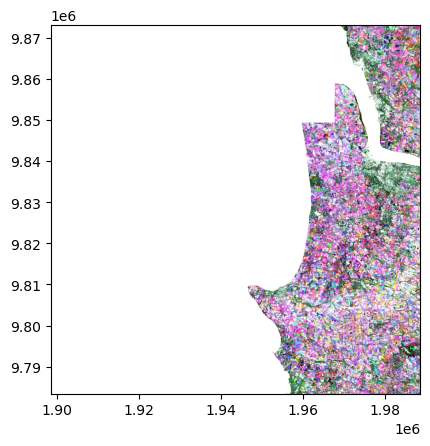

In [212]:
fn = f"/projects/shared-buckets/montesano/local_output/build_stack_S1/SAR_S1_2019_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif"
pct = [40,99.9]
pct = [75,99.9]

outdir = os.path.dirname(fn)
rescaled_multiband_fn = os.path.join(outdir, 'multi_band_temp.tif')

def rescale_pct_clip(array, pct=[1,80]):
    '''Re-scales data values of an array from 0-1 with percentiles'''
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0.00001
    return clip

with rasterio.open(fn, "r+") as src1:
    src1.nodata = -9999
    print(src1.profile)        
    arr1 = src1.read(1)
    arr2 = src1.read(2)
    arr3 = src1.read(3)
    arr4 = src1.read(4)
    arr5 = src1.read(5)
    arr6 = src1.read(6)
    #src1.profile['nodata'] = -9999
    with rasterio.open(multiband_fn, 'w+',
            driver='GTiff',
            dtype= rasterio.float32,
            count=3,
            crs = src1.crs,
            width=src1.width,
            height=src1.height,
            transform=src1.transform,
            nodata=src1.nodata
                       
        ) as dst:
        V = rescale_pct_clip(src1.read(1), pct=pct) / rescale_pct_clip(src1.read(2), pct=pct)
        dst.write(V,1)
        V = rescale_pct_clip(src1.read(3), pct=pct) / rescale_pct_clip(src1.read(4), pct=pct)
        dst.write(V,2)
        V = rescale_pct_clip(src1.read(5), pct=pct) / rescale_pct_clip(src1.read(6), pct=pct)
        dst.write(V,3)
                
fig,ax=plt.subplots()
with rasterio.open(rescaled_multiband_fn) as src:
    show(src.read(),transform=src.transform,ax=ax)
    bounds  = src.bounds

In [211]:
gdf = geopandas.GeoDataFrame({"tile_num":BUILD_STACK_DICT['TILE_NUM'],"geometry":[shapely.geometry.box(*bounds)]}, crs=src.crs)
gdf.to_crs(4326).explore(height=300, width = 500)

In [213]:
#s3.download('s3://maap-ops-workspace/montesano/dps_output/do_gee_download_by_subtile/EXPORT_GEE_v5/TEST_SAR_S1_2019/2023/12/28/22/10/04/430036/s1_vv_vh_gamma_2019_pwr_tile24-subtile003702/s1_vv_vh_gamma_2019_pwr_tile24-subtile003702.tif','/projects/my-public-bucket/local_output')

In [118]:
DPS_INPUT_TILE_NUM_LIST = []

### Use MAAP Registration call in notebook chunk to register DPS algorithm
 - We need to register a DPS algorithm called `run_build_stack_LC` before proceeding to the chunks below...

In [133]:
maap.register_algorithm_from_yaml_file("/projects/code/icesat2_boreal/dps/registered/run_build_stack.yml").text

'{"code": 200, "message": {"id": "1f81f09e87585f1a487a370fb0d0128653f74f0c", "short_id": "1f81f09e", "created_at": "2023-12-31T22:05:26.000+00:00", "parent_ids": ["c20fcdc766cccf29ebd525ab683a3925b4561163"], "title": "Registering algorithm: run_build_stack", "message": "Registering algorithm: run_build_stack", "author_name": "root", "author_email": "root@909fdfe9cc27", "authored_date": "2023-12-31T22:05:26.000+00:00", "committer_name": "root", "committer_email": "root@909fdfe9cc27", "committed_date": "2023-12-31T22:05:26.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/1f81f09e87585f1a487a370fb0d0128653f74f0c", "stats": {"additions": 0, "deletions": 0, "total": 0}, "status": "pending", "project_id": 3, "last_pipeline": {"id": 11035, "iid": 707, "project_id": 3, "sha": "1f81f09e87585f1a487a370fb0d0128653f74f0c", "ref": "main", "status": "pending", "source": "push", "created_at": "2023-12-31T22:05:28.091Z", "updated_at": "2023-12-3

In [1]:
#!aws s3 rm --recursive s3://maap-ops-workspace/montesano/dps_output/run_build_stack/LC_ESA_WC_2020
#!aws s3 mv s3://maap-ops-workspace/montesano/dps_output/run_build_stack/LC_ESA_WC_2020 s3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023

# Build a DPS list

In [54]:
#HLS_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv".replace('s3://maap-ops-workspace/shared/nathanmthomas', '/projects/my-public-bucket')
Topo_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv" #.replace('s3://maap-ops-workspace/shared/nathanmthomas', '/projects/my-public-bucket')

# Spring 2022 c2020 composite - use this as template set of tiles (5241 tiles)
HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master.csv'

s3 = s3fs.S3FileSystem(anon=True)

DPS_INPUT_TILE_NUM_LIST = []
for tindex_fn in [HLS_EXISTING_TINDEX_FN, Topo_tindex_master_fn]:
    tindex = pd.read_csv(tindex_fn, storage_options={'anon':True})
    
    print(len(tindex['tile_num'].values))
    
    if len(tindex['tile_num'].values) > len(DPS_INPUT_TILE_NUM_LIST):
        print(f"{len(tindex['tile_num'].values)} tiles in {tindex_fn}")
        print(f'{os.path.basename(tindex_fn)} has the most tiles. Using this for DPS tiles list.')
        DPS_INPUT_TILE_NUM_LIST = tindex['tile_num'].values

len(DPS_INPUT_TILE_NUM_LIST)
TILES_NEEDED = DPS_INPUT_TILE_NUM_LIST

5241
5241 tiles in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master.csv
HLS_tindex_master.csv has the most tiles. Using this for DPS tiles list.
5220


In [55]:
RUN_IRREGULAR_TILES = False

IRREGULAR_TILES_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv'

if RUN_IRREGULAR_TILES:
    DPS_INPUT_TILE_NUM_LIST = []
    print("Running DPS on irregular tiles that forces a shape of 3000...")
    df = pd.read_csv(IRREGULAR_TILES_FN)
    tile_num_list = []
    for i in df["IrregularTiles"]:
        tile_num = int(i.split('_')[9])
        DPS_INPUT_TILE_NUM_LIST.append(tile_num)
    print(len(DPS_INPUT_TILE_NUM_LIST))
    print(DPS_INPUT_TILE_NUM_LIST)

In [56]:
len(DPS_INPUT_TILE_NUM_LIST)

5241

### Params Dict for DPS
#### Note: make sure the `in_params_dict` coincides with the args of `build_stack.py`

In [57]:
S1_TRISEASON_YEAR = 2019
RUN = f'SAR_S1_{S1_TRISEASON_YEAR}'

In [58]:
#'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg',
in_params_dict = {
            'covar_tile_url': f'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v6/{RUN}/S1_subtile_tindex_master.gpkg',
            'in_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
            'covar_tile_fn': 'S1_subtile_tindex_master.gpkg',
            'in_tile_fn': 'boreal_tiles_v004.gpkg',
            'in_tile_id_col': 'tile_num',
            'in_tile_num':"",
            'tile_buffer_m': 0,
            'in_tile_layer': 'boreal_tiles_v004',
            #'output_dir': 'dummy',  # a dummy dir so i dont have to change the .yaml now
            #'topo_off': 'dummy', # functionality to turn off build a 'topo' stack is FALSE by default - so we have to set this flag (which turns OFF topo building) - this is hardcoded in the .sh now - if we want to build a topo stack with this script, need to learn how to set this flag with params dict 
            'covar_src_name': RUN,
            'bandnames_list': 'vv_median_frozen vh_median_frozen vv_median_summer vh_median_summer vv_median_shoulder vh_median_shoulder n_frozen n_summer n_shoulder',
            'in_covar_s3_col': 's3_path',
            'input_nodata_value': -9999,
            'shape': 3000
            #'clip': 'dummy' # this is hardcoded in the .sh now - if we want to build a topo stack with this script, need to learn how to set this flag with params dict 
        }

In [59]:
in_params_dict

{'covar_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v6/SAR_S1_2019/S1_subtile_tindex_master.gpkg',
 'in_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
 'covar_tile_fn': 'S1_subtile_tindex_master.gpkg',
 'in_tile_fn': 'boreal_tiles_v004.gpkg',
 'in_tile_id_col': 'tile_num',
 'in_tile_num': '',
 'tile_buffer_m': 0,
 'in_tile_layer': 'boreal_tiles_v004',
 'covar_src_name': 'SAR_S1_2019',
 'bandnames_list': 'vv_median_frozen vh_median_frozen vv_median_summer vh_median_summer vv_median_shoulder vh_median_shoulder n_frozen n_summer n_shoulder',
 'in_covar_s3_col': 's3_path',
 'input_nodata_value': -9999,
 'shape': 3000}

## DPS Test

### Use MAAP to submit a single test job
check status here

In [64]:
# MAAP algorithm version name
IDENTIFIER=f'build_stack_S1/TEST_{RUN}'
MAAP_VERSION = 'build_stack_v2023_2'
ALGO_ID = "run_build_stack"
USER = 'montesano'
WORKER_TYPE = 'maap-dps-worker-32gb'

In [65]:
RUN_NAME = IDENTIFIER

In [66]:
#BUILD_STACK_DICT

In [67]:
in_params_dict_TEST = in_params_dict
in_params_dict_TEST['in_tile_num'] = 4113 #3459
in_params_dict_TEST

{'covar_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/DPS_tile_lists/SAR/EXPORT_GEE_v6/SAR_S1_2019/S1_subtile_tindex_master.gpkg',
 'in_tile_url': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
 'covar_tile_fn': 'S1_subtile_tindex_master.gpkg',
 'in_tile_fn': 'boreal_tiles_v004.gpkg',
 'in_tile_id_col': 'tile_num',
 'in_tile_num': 4113,
 'tile_buffer_m': 0,
 'in_tile_layer': 'boreal_tiles_v004',
 'covar_src_name': 'SAR_S1_2019',
 'bandnames_list': 'vv_median_frozen vh_median_frozen vv_median_summer vh_median_summer vv_median_shoulder vh_median_shoulder n_frozen n_summer n_shoulder',
 'in_covar_s3_col': 's3_path',
 'input_nodata_value': -9999,
 'shape': 3000}

In [202]:
%%time
submitted_job_dict = maap.submitJob(
                identifier=IDENTIFIER,
                algo_id=ALGO_ID,
                version=MAAP_VERSION,
               username=USER,
               queue=WORKER_TYPE,
              **in_params_dict_TEST
            )

CPU times: user 22.8 ms, sys: 1.86 ms, total: 24.7 ms
Wall time: 293 ms


In [245]:
submitted_job_dict.status

'success'

In [ ]:
maap.getJobStatus("ae3c268b-8947-4df0-b6aa-ed177691a917")


In [205]:
print(submitted_job_dict)

{'job_id': '108e391b-6803-45e4-af7f-e61a38bdda32', 'status': 'success', 'machine_type': None, 'architecture': None, 'machine_memory_size': None, 'directory_size': None, 'operating_system': None, 'job_start_time': None, 'job_end_time': None, 'job_duration_seconds': None, 'cpu_usage': None, 'cache_usage': None, 'mem_usage': None, 'max_mem_usage': None, 'swap_usage': None, 'read_io_stats': None, 'write_io_stats': None, 'sync_io_stats': None, 'async_io_stats': None, 'total_io_stats': None, 'error_details': None, 'response_code': 200, 'outputs': []}


## Run a DPS job across a list

In [202]:
# First 2019 featured subtiles at agg tile borders that had nodata - These subtiles were redone in EXPORT_GEE_v6 and can now be re-run through build_stack
NODATA_AGGBORDER_TILES = list(range(3170,3213+1))
NODATA_AGGBORDER_TILES = [27636, 3570] + [3540,3634,3728,3823,3916,4004,41995,41807,41619] + list(range(2129,2229+1)) + list(range(277,300+1)) + list(range(712,737+1)) + list(range(45,53+1)) +\
 list(range(27385,27364+1)) + list(range(2156, 2196+1)) + list(range(3122, 3167+1)) + list(range(4204, 4212+1))+ list(range(4214, 4224+1))+\
[2828,2911,2998,3087,3272,3365,3458,3553,3647,3741,3835,3928,4016,4160]

NODATA_AGGBORDER_TILES = [1992,1207] + [1921,1993,2063,2136,2211,2288,2365,2446,2527,2608,2688,2796,2852,2935,3022,3111,3296,3389,3482,3577,
                                        3671,3765,3859,3952,4034,3847,3756,3659,3565,3470,3377,3284,3099,3010,2923,2840,2757,2676,2596,2515,2434,2353,2276,2124] 

NODATA_AGGBORDER_TILES = [3753,2620,2539,2458,2377,2300,2075,2005,1933,1862,1794,1727,1668,1611,1555,1498,1441,1385,1327,1152,1098,1043,987,937,889,843,797,751,706,661,537,497,457,423,36019,35799,35577,35351,1086,1031,975,877,831]
NODATA_AGGBORDER_TILES = list(range(1440,1450+1))+[37145,36919,36694,36470,36245,36022,35802,35580,35355,35128,34903]
NODATA_AGGBORDER_TILES = [2620,2539,35355] 
NODATA_AGGBORDER_TILES = [36468,36244,38433,1941,2769,269,23548,23829,23547,23828] 

MISSING_SUBTILE_TILES = list(range(745,754+1)) + [937,987,1207,1266,1271] + [3176,3177,3178]
MISSING_SUBTILE_TILES = [35128,36693,36244,36246,36247]
MISSING_SUBTILE_TILES = list(range(24055,24061+1)) + [23782]
MISSING_SUBTILE_TILES = [83,102,122,143,165,188,262,345,377,409,441,481,523,564,826,873,922,972,1027,1084,1139,1193,1250,1310,1484,1541,1597,1652,1708,1768,1835,1904,1974,2043,2260,2031,1962,1892,1823,1640,1585,1529,1472,1298,1297,1238,1237,1181,1180,1127,1126,1072,1071,1015,1014,960,959,910,909,861,860,814,813,678,677,634,633,593,592,552,551,511,510,469,468,429,428,397,396,365,364,333,332,30255]
MISSING_SUBTILE_TILES = [24670,24389,24108,24109,23827,23828,23547,22938]
boreal_tiles = geopandas.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg')
agg_tiles_index = geopandas.read_file('/projects/my-public-bucket/databank/boreal_tiles_v004_agg12/boreal_tiles_v004_agg12.gpkg')
agg_tiles_index['tile_num'] = agg_tiles_index['agg_tile_num']

# Convert Polygon GeoDataFrame to LineString GeoDataFrame
line_gdf = geopandas.GeoDataFrame(geometry=agg_tiles_index[agg_tiles_index.tile_num.isin([66,42,39,35,21,18,14,13,16,7,11,3,9,5,22,49,19,20,33,65,38,51,40,12,62,32])]['geometry'].boundary)

# Perform a spatial join to identify polygons that intersect lines
MUST_FIX = geopandas.sjoin(boreal_tiles, line_gdf, how='inner', op='intersects')

NODATA_AGGBORDER_TILES = MUST_FIX.tile_num.to_list()

len(MISSING_SUBTILE_TILES)

/projects/env/above/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


8

In [203]:
#DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_TILES
DPS_INPUT_TILE_NUM_LIST = MISSING_SUBTILE_TILES

In [204]:
RUN

'SAR_S1_2019'

In [205]:
# MAAP algorithm version name
IDENTIFIER=f'build_stack_S1/{RUN}'
MAAP_VERSION = 'build_stack_v2023_2'
ALGO_ID = "run_build_stack"
USER = 'montesano'
WORKER_TYPE = 'maap-dps-worker-32gb'

In [206]:
RUN_NAME = IDENTIFIER
RUN_NAME

'build_stack_S1/SAR_S1_2019'

In [207]:
%%time

submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):
    
    DPS_num = i+1
    
    # Update the in_params_dict with th current INPUT_TILE_NUM
    in_params_dict['in_tile_num'] = INPUT_TILE_NUM
    
    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version=MAAP_VERSION,
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_params_dict
        )
    
    #print(submit_result)
    #break
    
    # Build a dataframe of submission details
    submit_result_df = pd.DataFrame( 
        {
                'dps_num':[DPS_num],
                'tile_num':[INPUT_TILE_NUM],
                'submit_time':[datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%s')],
                'dbs_job_hour': [datetime.datetime.now().hour],
                'algo_id': [ALGO_ID],
                'user': [USER],
                'worker_type': [WORKER_TYPE],
                'job_id': [submit_result.id],
                'submit_status': [submit_result.status],
            
        } 
    )
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(submit_result_df)
    
    if DPS_num in [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result.status}\t| job id: {submit_result.id}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{RUN}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()


# of input tiles for DPS: 8
DPS run #: 1	| tile num: 24670	| submit status: success	| job id: fe723451-b2a0-436b-ba9c-c5c522abd22e
DPS run #: 5	| tile num: 23827	| submit status: success	| job id: 3956acd8-2e9a-4ad0-968d-6579a7af0f08
DPS run #: 8	| tile num: 22938	| submit status: success	| job id: 37f8ad91-9a93-4450-bd7b-83f378d931ac
Current time:	202401070648
<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dps_num        8 non-null      int64 
 1   tile_num       8 non-null      int64 
 2   submit_time    8 non-null      object
 3   dbs_job_hour   8 non-null      int64 
 4   algo_id        8 non-null      object
 5   user           8 non-null      object
 6   worker_type    8 non-null      object
 7   job_id         8 non-null      object
 8   submit_status  8 non-null      object
 9   run_name       8 non-null      object
dtypes: int64(3), object

## Build tindex

In [208]:
DPS_IDENTIFIER = f'{MAAP_VERSION}/{IDENTIFIER}'
DPS_MONTH_LIST = '01 12'
DPS_YEAR_LIST = '2023 2024'
TYPE = 'S1'

DPS_DAY_MIN = 1
OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/{ALGO_ID}/{DPS_IDENTIFIER}'
!mkdir -p $OUTDIR

# Build tindex
args = f"--RETURN_DUPS \
--user {USER} \
--dps_identifier {DPS_IDENTIFIER} \
-alg_name {ALGO_ID} \
-t {TYPE} \
-y_list {DPS_YEAR_LIST} \
--dps_month_list {DPS_MONTH_LIST} \
-d_min {DPS_DAY_MIN} \
--outdir {OUTDIR}"

!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args 

NASA MAAP
INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
NASA MAAP

Building a list of tiles:
DPS ID:		build_stack_v2023_2/build_stack_S1/SAR_S1_2019
Type:		S1
Year:		['2023', '2024']
Month:		['01', '12']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/run_build_stack/build_stack_v2023_2/build_stack_S1/SAR_S1_2019
# of duplicate tiles: 2134
Final # of tiles: 5287
Writing duplicates csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack/build_stack_v2023_2/build_stack_S1/SAR_S1_2019/S1_tindex_master_duplicates.csv
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack/build_stack_v2023_2/build_stack_S1/SAR_S1_2019/S1_tindex_master.csv
Building geodataframe of matches, tindex master json, and mosaic json...
Tile index matches geodataframe for json: (5287, 7)
Building /projects/my-public-bucket/DPS_tile_lists/run_build_stack/build_stack_

## Read tindex and get missing tiles

In [265]:
boreal_tile_index = geopandas.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg')
df = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/build_stack_v2023_2/LC_ESA_WC_2020/LC_tindex_master.csv')
df.head()

,Unnamed: 0,s3_path,local_path,file,tile_num,creation time
0,5244,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_3611_cog.tif,3611,2023-12-07 10:46:24
1,5243,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_1674_cog.tif,1674,2023-12-07 10:40:25
2,5242,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_3618_cog.tif,3618,2023-12-07 10:36:42
3,5241,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_4262_cog.tif,4262,2023-12-07 10:36:39
4,5240,s3://maap-ops-workspace/montesano/dps_output/r...,/projects/my-private-bucket/dps_output/run_bui...,esa_worldcover_v100_2020_3852_cog.tif,3852,2023-12-07 10:31:30


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     5238 non-null   int64 
 1   s3_path        5238 non-null   object
 2   local_path     5238 non-null   object
 3   file           5238 non-null   object
 4   tile_num       5238 non-null   int64 
 5   creation time  5238 non-null   object
dtypes: int64(2), object(4)
memory usage: 245.7+ KB


In [267]:
boreal_tile_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   tile_num      5337 non-null   int64   
 1   tile_version  5337 non-null   object  
 2   tile_group    5337 non-null   object  
 3   map_version   0 non-null      float64 
 4   geometry      5337 non-null   geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 208.6+ KB


In [268]:
boreal_tindex_params = boreal_tile_index.merge(df[['tile_num']], how='right', left_on='tile_num', right_on='tile_num')

CURRENT_MISSING_TILES = list(set(TILES_NEEDED) - set(boreal_tindex_params.tile_num.to_list()))
n_tiles_missing = len(CURRENT_MISSING_TILES)

CURRENT_MISSING_tindex_gdf = boreal_tile_index[boreal_tile_index.tile_num.isin(CURRENT_MISSING_TILES)]

In [269]:
n_tiles_missing

3

In [270]:
print(CURRENT_MISSING_TILES)

[4289, 66, 4269]


/projects/code/icesat2_boreal/lib/ExtractUtils.py:506: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )


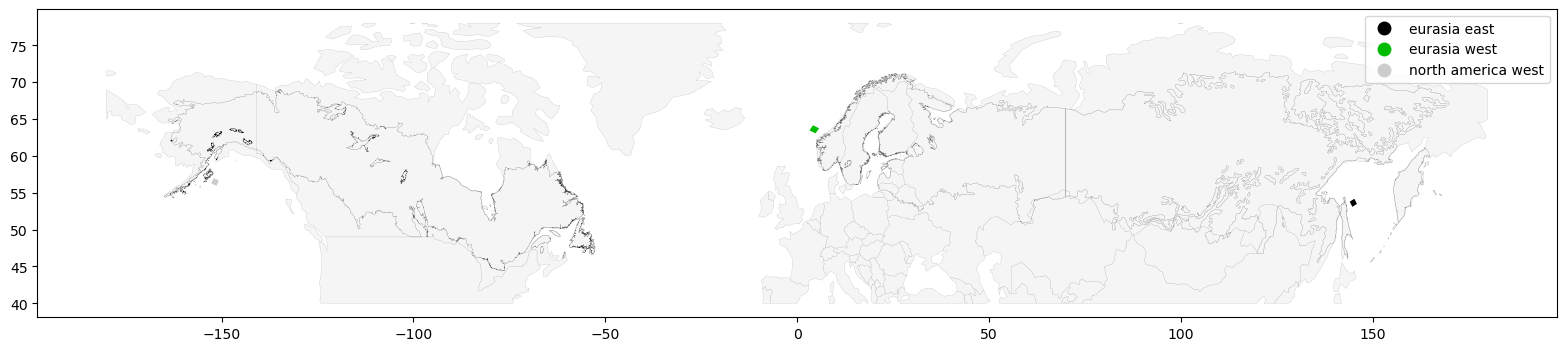

In [271]:
ax_missing = ExtractUtils.plot_gdf_on_world(CURRENT_MISSING_tindex_gdf, MAP_COL='tile_group', DO_TYPE='False')
#ax_missing.set_title(f'{YEAR}: {n_tiles_missing} core tiles missing (might not be critical)')